In [1]:
#Burası github dan denediğin proje

Categorized Color Counts:
pink: 1
silver: 4
darkgray: 2
gray: 1
sienna: 1
black: 3
dimgray: 4
darkolivegreen: 3
tan: 4
darkslategray: 4
rosybrown: 2


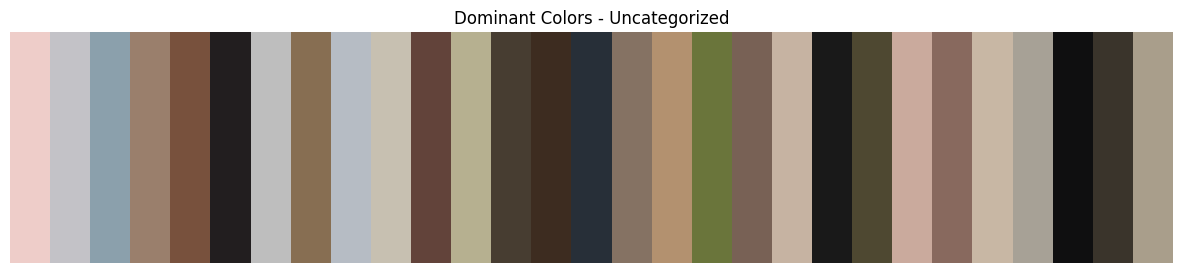

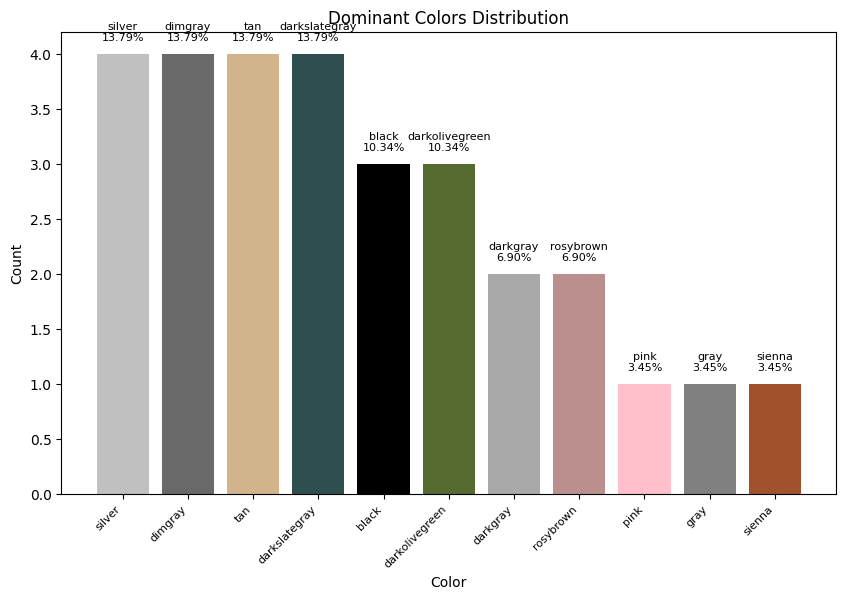

In [3]:
import os
from bs4 import BeautifulSoup
import requests
from io import BytesIO
from PIL import Image
from colorthief import ColorThief
import colorsys
import matplotlib.pyplot as plt
from collections import Counter
import webcolors
import matplotlib.pyplot as plt

def closest_color(rgb):
    differences = {}
    for color_hex, color_name in webcolors.CSS3_HEX_TO_NAMES.items():
        r,g,b = webcolors.hex_to_rgb(color_hex)
        differences[sum([(r- rgb[0]) ** 2,
                         (g - rgb[1]) ** 2,
                         (b - rgb[2]) ** 2])] = color_name
    return differences[min(differences.keys())]

# Dictionary to store the counts of dominant colors
dominant_color_counts = Counter()

# Replace 'PATH_TO_YOUR_HTML_FILE' with the actual path to your saved Pinterest HTML file
html_file_path = "C:/Users/alica/OneDrive - sabanciuniv.edu/Masaüstü/Cansu/Sophmore 2/CS210/ucuncuPinterest.html"

# Get the directory of the HTML file
html_file_directory = os.path.dirname(html_file_path)

with open(html_file_path, 'r', encoding='utf-8') as file:
    content = file.read()

soup = BeautifulSoup(content, 'html.parser')
 
# Find all image elements on the page
image_elements = soup.find_all('img')

# Extract image URLs
image_urls = [img['src'] for img in image_elements if 'src' in img.attrs]

# List to store the dominant colors for each image
all_dominant_colors = []



# Analyze dominant colors for each image
for image_url in image_urls:
    # Construct the full file path
    image_path = os.path.join(html_file_directory, image_url.replace('/', '\\'))

    # Using ColorThief for dominant color analysis
    ct = ColorThief(image_path)

    dominant_color = ct.get_color(quality=1)

    # Add the dominant color to the Counter
    dominant_color_counts[dominant_color] += 1
    all_dominant_colors.append(dominant_color)



most_common_color = dominant_color_counts.most_common(1)[0][0]



##############################3

# Display the categorized colors and write to a file
categorized_colors = [closest_color(color) for color in all_dominant_colors]
color_counts = Counter(categorized_colors)

print("Categorized Color Counts:")
for color, count in color_counts.items():
    print(f"{color}: {count}")
    


# Display all dominant colors in one graph if there are more than one image
if len(all_dominant_colors) > 1:
    fig, ax = plt.subplots(figsize=(15, 3))

    # Convert to a NumPy array
    color_array = all_dominant_colors

    # Plot and display the colors using the 'viridis' colormap
    ax.imshow([color_array], cmap='viridis', aspect='auto')
    ax.axis('off')
    plt.title('Dominant Colors - Uncategorized')
    plt.show()
else:
    print("Not enough images to create a graph.")


# Get the total number of images
total_images = len(all_dominant_colors)

# Calculate the percentages
percentages = {color: count / total_images * 100 for color, count in color_counts.items()}

# Sort the colors by count in descending order
sorted_colors = sorted(color_counts.items(), key=lambda x: x[1], reverse=True)

# Extract information for plotting
colors = [color[0] for color in sorted_colors]
counts = [color[1] for color in sorted_colors]
percentages = [percentages[color] for color in colors]

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
plt.title('Dominant Colors- Uncategorized')
bars = plt.bar(range(len(colors)), counts, color=colors)

# Annotate with color names and percentages
for bar, color, percentage in zip(bars, colors, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f"{color}\n{percentage:.2f}%", 
             ha='center', va='bottom', rotation=0, fontsize=8, color='black')

# Customize the plot
plt.xticks(range(len(colors)), colors, rotation=45, ha='right', fontsize=8)
plt.xlabel('Color')
plt.ylabel('Count')
plt.title('Dominant Colors Distribution')

# Show the plot
plt.show()



1/1 [==============================] - 0s 101ms/step


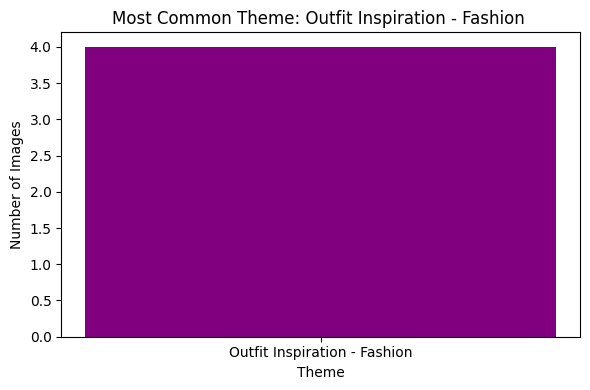

In [7]:
import os
from bs4 import BeautifulSoup
from collections import Counter
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image


# Define refined themes and their corresponding keywords
theme_keywords = {
    'Outfit Inspiration - Fashion': ['outfit', 'fashion', 'style', 'clothing', 'dress', 'apparel','skirt', 'miniskirt','abaya', 'jean','gown'
                           ,'brassiere','kimono', 'bikini','maillot','suit','vest','cardigan','handkerchief', 'overskirt','bag'
                           ,'mailbag','coat','wardrobe','trench_coat','poncho','sandal','Loafer','sunglasses', 'tank top','fur_coat','feather_boa'],
    'Nails': ['nails', 'manicure', 'nail art', 'polish', 'nail design','hair_spray', 'sunglass'],
    'Makeup and Hair': ['makeup', 'hair', 'beauty', 'cosmetics', 'hairstyle', 'lipstick', 'powder'
                        , 'face_powder','wig', 'perfume','skin','care','skin care','eyes','lashes','tick'],
    'Manifesting- Motivation': ['manifesting', 'law of attraction', 'positivity', 'affirmation'
                                , 'inspiration', 'notebook', 'iPod','envelope','eraser','pencil','rubber_eraser'
                                ,'candle','desk','pencil_box','book', 'book shelf'],
    'Pictures for moods': ['mood', 'emotions', 'feelings', 'expression', 'vibe', 'aesthetic','lakeside'
                           ,'swimming_trunks', 'animals','Chihuahua','seashore','bookshop'
                           ,'entertainment_center','red_wine','animal','cartoon','Winnie the poo', 'coffee', 'friends','fun','tree','valley'],
    'Healthy Life': ['workout', 'fitness', 'exercise', 'gym', 'yoga', 'health','cucumber','ski','hot_pot', 'baseball', 'zucchini'],
    'Playlists': ['playlist', 'music', 'songs', 'audio', 'tunes'],
    'Decoration': ['decoration', 'decor', 'home', 'interior', 'furniture', 'design','library','castle'
                   ,'microwave','pot','window','table','dining_table', 'room','bed', 'chair' ],
    'Drawing Ideas - Art': ['drawing', 'art', 'sketch', 'illustration', 'painting', 'doodle','slot'],
    'Knitting': ['knitting', 'crafts', 'handmade', 'yarn', 'crochet', 'stitch','crochet pattern'],
    'Wallpaper': ['wallpaper', 'background', 'desktop', 'screen', 'theme', 'pattern','promontory'],   
}


# Load MobileNetV2 model
model = MobileNetV2(weights='imagenet')


# Function to get image category from TensorFlow
def get_image_category(img_path):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        predictions = model.predict(img_array)
        decoded_predictions = decode_predictions(predictions)
        top_category = decoded_predictions[0][0][1]
        return top_category.lower()  # Convert to lowercase for consistency
    except Exception as e:
        print(f"Error analyzing image {img_path}: {e}")
        return None
    
    # Function to score themes based on keywords and TensorFlow predictions
def score_themes(text, predicted_category, theme_keywords):
    theme_scores = {theme: 0 for theme in theme_keywords}
    for theme, keywords in theme_keywords.items():
        for keyword in keywords:
            if keyword in text:
                theme_scores[theme] += 1
        if predicted_category and predicted_category in keywords:
            theme_scores[theme] += 2  # Higher weight for TensorFlow prediction match
    return theme_scores
    



# Replace with the actual path to your saved Pinterest HTML file
html_file_path = "C:/Users/alica/OneDrive - sabanciuniv.edu/Masaüstü/Cansu/Sophmore 2/CS210/ucuncuPinterest.html"


# Read and parse the HTML file
with open(html_file_path, 'r', encoding='utf-8') as file:
    content = file.read()



soup = BeautifulSoup(content, 'html.parser')
image_elements = soup.find_all('img')

theme_counts = Counter()




# Add a fallback category
theme_keywords['Miscellaneous'] = []


# Analyze themes for each image
for img in image_elements:
    if 'src' in img.attrs:
        image_url = img['src']
        filename = os.path.basename(image_url.lower())
        alt_text = img.get('alt', '').lower()
        image_path = os.path.join(html_file_directory, image_url.replace('/', '\\'))

        # Get TensorFlow predicted category
        tf_category = get_image_category(image_path)

        # Scoring themes
        theme_scores = score_themes(filename + ' ' + alt_text, tf_category, theme_keywords)
        top_theme = max(theme_scores, key=theme_scores.get)

        # Fallback to 'Miscellaneous' if no keywords matched
        top_theme = top_theme if theme_scores[top_theme] > 0 else 'Miscellaneous'

        theme_counts[top_theme] += 1
        

# Find the most common theme excluding 'Miscellaneous'
filtered_theme_counts = {theme: count for theme, count in theme_counts.items() if theme != 'Miscellaneous'}
most_common_theme = max(filtered_theme_counts, key=filtered_theme_counts.get)
most_common_count = filtered_theme_counts[most_common_theme]

# Plotting the graph for the most common theme
plt.figure(figsize=(6, 4))
plt.bar(most_common_theme, most_common_count, color='purple')
plt.xlabel('Theme')
plt.ylabel('Number of Images')
plt.title(f'Most Common Theme: {most_common_theme} ')
plt.tight_layout()
plt.show()